# Image Cleanser Pipeline


In [1]:
params = {
    "on_Google_drive": False,
    "copy_from_original": False,
    "download_dataset": False,
    "train_M": False,
}

## R and R_prime

### Environment

In [2]:
if not params["on_Google_drive"]:
  print ("Skipping mounting Google Drive")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  os.chdir('/content/drive/MyDrive/UCSD_COURSES/ECE253/ImageCleanser/repos/ImageCleanser')

Skipping mounting Google Drive


In [16]:
%pip install parameters fire lmdb pillow torchvision nltk natsort datasets

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import re
import shutil
import fire
import lmdb
import PIL, PIL.Image, PIL.ExifTags, PIL.ImageOps
# --- fix Pillow >=10 for Hugging Face datasets ---
if not hasattr(PIL.Image, "ExifTags"):
    PIL.Image.ExifTags = PIL.ExifTags
if not hasattr(PIL.ExifTags, "Base"):
    class _Base:
        Orientation = 274
    PIL.ExifTags.Base = _Base
from datasets import load_dataset
from tqdm import tqdm

### Upload and Download Data

In [10]:
# !zip -r D_prime.zip datasets/D_prime

# if not params["download_dataset"]:
#   print ("Skipping downloading dataset")
# else:
#   %pip install -q gdown
#   !gdown --id 14Hveo70hTod8WOb3kh3_vDpkN6FC5f-T -O D_prime.zip
#   !unzip -q D_prime.zip -d .

/home/xun_liu/.local/lib/python3.8/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14Hveo70hTod8WOb3kh3_vDpkN6FC5f-T
From (redirected): https://drive.google.com/uc?id=14Hveo70hTod8WOb3kh3_vDpkN6FC5f-T&confirm=t&uuid=c3bf2da2-c39e-4dd6-81f8-f14de0df4b22
To: /home/xun_liu/Projects/ImageCleanser/D.zip
100%|██████████████████████████████████████| 94.9M/94.9M [00:03<00:00, 27.0MB/s]


In [12]:
# Create output directories
os.makedirs("datasets/MJ600/images", exist_ok=True)

# Load in streaming mode (no full download)
dataset = load_dataset(
    "priyank-m/MJSynth_text_recognition",
    split="train",
    streaming=True
)

# Stream and save 600 samples
max_samples = 600
records = []
for i, sample in enumerate(tqdm(dataset, total=max_samples)):
    if i >= max_samples:
        break
    img = sample["image"]
    label = str(sample["label"]).strip().replace(" ", "")
    fname = f"{i+1}_{label}.jpg"
    img.save(f"datasets/MJ600/images/{fname}")
    records.append((fname, label))

print(f"✅ Saved {len(records)} images to datasets/MJ600/images")

# --- Create MJ600.txt for LMDB ---
txt_path = "datasets/MJ600.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    for fname, label in sorted(
        records, key=lambda x: [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', x[0])]
    ):
        f.write(f"{fname}\t{label}\n")

print(f"✅ Wrote label file: {txt_path}")

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:00<00:00, 605.88it/s]

✅ Saved 600 images to datasets/MJ600/images
✅ Wrote label file: datasets/MJ600.txt


In [15]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [18]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 46.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import cv2

In [21]:
    image_directory_original = 'datasets/MJ600/images'
    # IMPORTANT: Replace '/path/to/your/original/dataset/gt.txt' with the actual path to your original gt.txt file
    gt_file_original = 'datasets/MJ600/MJ600.txt'
    lmdb_output_dir = 'datasets/MJ600/MJ600_lmdb' # Output directory for the new LMDB

    # Create the output directory if it doesn't exist
    os.makedirs(lmdb_output_dir, exist_ok=False)


    # Ensure the create_lmdb_dataset.py script exists in your current directory
    if os.path.exists('create_lmdb_dataset.py'):
        print(f"Creating LMDB dataset from {image_directory_original} to {lmdb_output_dir} using {gt_file_original}...")
        # The script create_lmdb_dataset.py expects inputPath, gtFile, and outputPath positionally
        create_lmdb_command = f'python3 create_lmdb_dataset.py {image_directory_original} {gt_file_original} {lmdb_output_dir}'
        !{create_lmdb_command}
        print("LMDB dataset creation finished.")
    else:
        print("Error: create_lmdb_dataset.py not found. Please make sure it's in the current directory.")

Creating LMDB dataset from datasets/MJ600/images to datasets/MJ600/MJ600_lmdb using datasets/MJ600/MJ600.txt...
Created dataset with 600 samples
LMDB dataset creation finished.


In [59]:
!python3 test.py \
--eval_data datasets/D_prime/D_prime_lmdb\
--data_filtering_off \
--Transformation None --FeatureExtraction VGG --SequenceModeling None --Prediction CTC \
--saved_model saved_models/None-VGG-None-CTC.pth

No Transformation module specified
No SequenceModeling module specified
model input parameters 32 100 20 1 512 256 37 25 None VGG None CTC
loading pretrained model from saved_models/None-VGG-None-CTC.pth
test.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fi

In [60]:
!python3 test.py \
--eval_data datasets/MJ600/MJ600_lmdb \
--data_filtering_off \
--Transformation None --FeatureExtraction VGG --SequenceModeling None --Prediction CTC \
--saved_model saved_models/None-VGG-None-CTC.pth

No Transformation module specified
No SequenceModeling module specified
model input parameters 32 100 20 1 512 256 37 25 None VGG None CTC
loading pretrained model from saved_models/None-VGG-None-CTC.pth
test.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fi

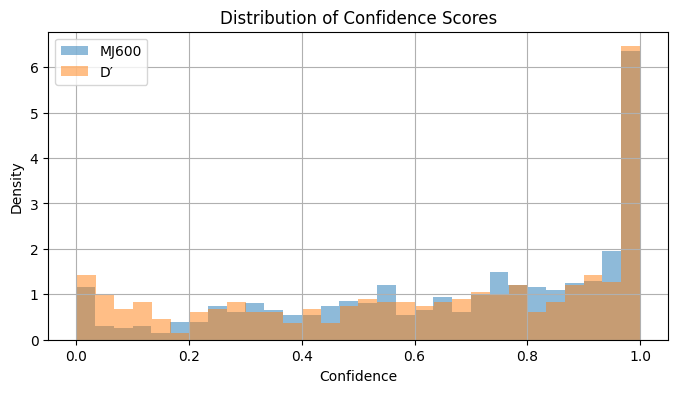

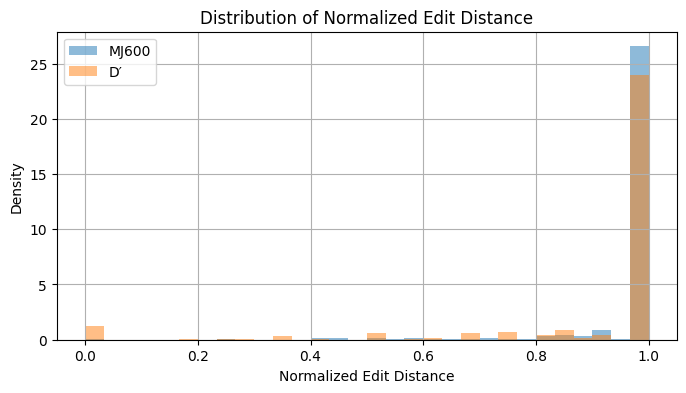

confidence                                                        \
             count      mean       std           min       25%       50%   
dataset                                                                    
D′           400.0  0.626958  0.327032  1.098225e-03  0.359012  0.697606   
MJ600        600.0  0.674168  0.295927  2.370159e-07  0.462905  0.757410   

                       norm_edit_distance                                     \
              75%  max              count      mean       std  min  25%  50%   
dataset                                                                        
D′       0.936707  1.0              400.0  0.907277  0.236754  0.0  1.0  1.0   
MJ600    0.950781  1.0              600.0  0.969939  0.106686  0.0  1.0  1.0   

                   
         75%  max  
dataset            
D′       1.0  1.0  
MJ600    1.0  1.0

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load your two result CSVs ---
df1 = pd.read_csv("./result/None-VGG-None-CTC.pth/MJ600_detailed_results.csv")
df2 = pd.read_csv("./result/None-VGG-None-CTC.pth/D_prime_detailed_results.csv")

# Label each dataset
df1["dataset"] = "MJ600"
df2["dataset"] = "D′"

# Combine for summary
df_all = pd.concat([df1, df2], ignore_index=True)

# --- Confidence Distribution ---
plt.figure(figsize=(8, 4))
plt.hist(df1["confidence"], bins=30, alpha=0.5, label="MJ600", density=True)
plt.hist(df2["confidence"], bins=30, alpha=0.5, label="D′", density=True)
plt.title("Distribution of Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# --- Normalized Edit Distance Distribution ---
plt.figure(figsize=(8, 4))
plt.hist(df1["norm_edit_distance"], bins=30, alpha=0.5, label="MJ600", density=True)
plt.hist(df2["norm_edit_distance"], bins=30, alpha=0.5, label="D′", density=True)
plt.title("Distribution of Normalized Edit Distance")
plt.xlabel("Normalized Edit Distance")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# --- Summary statistics ---
summary = df_all.groupby("dataset")[["confidence", "norm_edit_distance"]].describe()
display(summary)
